<a href="https://colab.research.google.com/github/Mayakshanesht/Semantic-Segmentation/blob/main/Semantic_segmentation_drivableAreaNetwork1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#lets mount drive on the google colab
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/segmentation/segmentation_course-master/dataset/dataset")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
costa_rica_challenge.mp4  labels_3000_160.p	SegmentationTest.h5
images_3000_160.p	  SegmentationTest2.h5


In [1]:
#lets import important python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import cv2
import random
import time

In [2]:
#lets install tensorflow
import tensorflow as tf
print(tf.__version__)

2.6.0


In [5]:
with open('images_3000_160.p','rb') as f:
  images=pickle.load(f)
with open('labels_3000_160.p','rb') as f:
  labels=pickle.load(f) 

In [6]:
label1=[]
for label in labels:
  for x in range(label.shape[0]):
    for y in range(label.shape[1]):
      if(np.all(label[x][y]==[0,0,0])):
        label[x][y]=[0,1,0]
        label1.append(label)

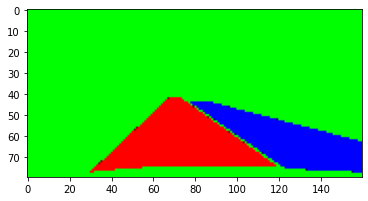

In [7]:
plt.imshow(label1[1])

In [8]:
label1[0].shape

(80, 160, 3)

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [10]:
images=np.array(images[0:2999])
images1=np.array(images[0:2999])
label1=np.array(label1[0:2999])
images,labels1=shuffle(images,label1)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(images, labels1, test_size=0.15)
n_train = len(X_train)
n_val = len(X_val)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization,Conv2DTranspose,add,Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, *pool_size, 1]
        padding = padding.upper()
        strides = [1, *strides, 1]
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=ksize,
            strides=strides,
            padding=padding)

        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        mask = K.cast(mask, 'int32')
        input_shape = tf.shape(updates, out_type='int32')

        if output_shape is None:
            output_shape = (
                input_shape[0],
                input_shape[1] * self.size[0],
                input_shape[2] * self.size[1],
                input_shape[3])

        ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                            K.flatten(updates),
                            [K.prod(output_shape)])

        input_shape = updates.shape
        out_shape = [-1,
                     input_shape[1] * self.size[0],
                     input_shape[2] * self.size[1],
                     input_shape[3]]
        return K.reshape(ret, out_shape)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3]
        )

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import BatchNormalization
#import MaxPoolingWithArgmax2D
#import MaxUnpooling2D


def create_segnet(input_shape,
                  n_labels,
                  num_filters=32,
                  output_mode="softmax"):
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv_1)

    conv_2 = Convolution2D(2 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(pool_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv_2)

    conv_3 = Convolution2D(2 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(pool_2)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv_3)

    conv_4 = Convolution2D(4 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(pool_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(conv_4)

    unpool_1 = MaxUnpooling2D(size=(2, 2))([pool_4, mask_4])

    conv_5 = Convolution2D(2 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)

    unpool_2 = MaxUnpooling2D(size=(2, 2))([conv_5, mask_3])

    conv_6 = Convolution2D(2 * num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)

    unpool_3 = MaxUnpooling2D(size=(2, 2))([conv_6, mask_2])

    conv_7 = Convolution2D(num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    unpool_4 = MaxUnpooling2D(size=(2, 2))([conv_7, mask_1])

    conv_8 = Convolution2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_8 = BatchNormalization()(conv_8)
    outputs = Activation(output_mode)(conv_8)

    segnet = Model(inputs=inputs, outputs=outputs)
    return segnet

model=create_segnet(input_shape=(80,160,3),
                  n_labels=3,
                  num_filters=32,
                  output_mode="softmax")

In [ ]:
model.summary()

In [13]:
def encoder_decoder_skip_connections(input_shape= (160,80,3), pool_size=(2,2), dropout_rate=0.5):
    """
    Here, build your killer segmentation network.
    Use any technique that can be useful.
    Credits for the architecture: https://towardsdatascience.com/lane-detection-with-deep-learning-part-2-3ba559b5c5af
    """
    # ENCODER
    input_x = Input(shape=(80,160,3))
    x1 = BatchNormalization(input_shape=input_shape)(input_x)
    ## CONV 1
    x = Conv2D(8, (3, 3), strides = (1,1), activation='relu', padding='valid')(x1)
    ## CONV 2 + SKIP CONNECTION
    x = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    ## CONV 3
    x = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    ## CONV4 + SKIP CONNECTION
    x2 = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x2)
    ## CONV5
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    ## CONV6
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    ## CONV7
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    
    # DECODER
    ## UPSAMPLING 7
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 6
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 5
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)

    ## UPSAMPLING 4
    x = add([x2, x])
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 3
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 2
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)

    ## UPSAMPLING 1
    x = Conv2DTranspose(3, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = add([x1, x])
    x = Conv2D(3, (1,1), padding=('valid'), strides=(1,1), activation='softmax')(x)
    return Model(input_x,x)
model = encoder_decoder_skip_connections()
model.summary()





Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 160, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 160, 3)   12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 158, 8)   224         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 156, 16)  1168        conv2d[0][0]                     
______________________________________________________________________________________________

In [14]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics='accuracy')

In [15]:
model.fit(X_train,y_train,epochs=20,validation_data=(X_val,y_val))

Epoch 1/20
80/80 [==============================] - 42s 132ms/step - loss: 0.5378 - accuracy: 0.7639 - val_loss: 0.5660 - val_accuracy: 0.7633
Epoch 2/20
80/80 [==============================] - 9s 107ms/step - loss: 0.3610 - accuracy: 0.8275 - val_loss: 0.3929 - val_accuracy: 0.8260
Epoch 3/20
80/80 [==============================] - 9s 107ms/step - loss: 0.2991 - accuracy: 0.8670 - val_loss: 0.3180 - val_accuracy: 0.8702
Epoch 4/20
80/80 [==============================] - 9s 107ms/step - loss: 0.2773 - accuracy: 0.8847 - val_loss: 0.3112 - val_accuracy: 0.8809
Epoch 5/20
80/80 [==============================] - 9s 106ms/step - loss: 0.2655 - accuracy: 0.8905 - val_loss: 0.2800 - val_accuracy: 0.8886
Epoch 6/20
80/80 [==============================] - 9s 107ms/step - loss: 0.2570 - accuracy: 0.8949 - val_loss: 0.2867 - val_accuracy: 0.8869
Epoch 7/20
80/80 [==============================] - 9s 107ms/step - loss: 0.2486 - accuracy: 0.8998 - val_loss: 0.2811 - val_accuracy: 0.8933
Epoch

In [16]:
def rgb_channel(img, thresholding=False, thresh=230):
    """Threshold the re-drawn images"""
    image = np.copy(img)
    if thresholding:
        ret, image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return R,G,B

In [17]:
def run(input_image):
    h,w,d = input_image.shape
    network_image = input_image.copy()
    network_image = cv2.resize(network_image, (160,80), interpolation=cv2.INTER_AREA)
    #network_image=cv2.cvtColor(network_image,cv2.COLOR_BGR2GRAY)
    network_image = network_image[None,:,:,:]
    prediction = model.predict(network_image)[0]*255
    R,G,B = rgb_channel(prediction)
    blank = np.zeros_like(R).astype(np.uint8)
    lane_image = np.dstack((R,blank,blank))
    lane_image = cv2.resize(lane_image, (w,h))
    result = cv2.addWeighted(input_image, 1, lane_image.astype(np.uint8), 1, 0)
    return result

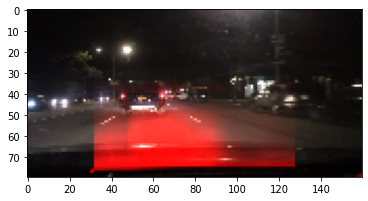

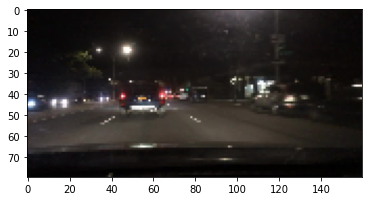

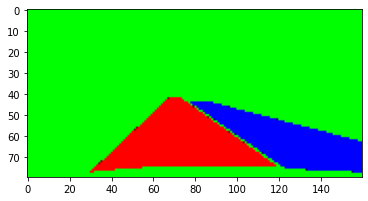

In [18]:
index=0
predict_image = images[index]
plt.imshow(run(predict_image))
plt.show()
plt.imshow(images[index])
plt.show()
plt.imshow(labels1[index])
plt.show()

In [19]:
result_video=[]
for img in images1:
  result_video.append(run(img))



In [20]:
h,w,d = images[0].shape
out = cv2.VideoWriter('/content/drive/My Drive/segmentation/movie_track101.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

In [22]:
from moviepy.editor import VideoFileClip

video_file = "/content/drive/My Drive/segmentation/segmentation_course-master/dataset/dataset/costa_rica_challenge.mp4"
clip = VideoFileClip(video_file)
white_clip = clip.fl_image(run)
%time white_clip.write_videofile("/content/drive/My Drive/segmentation/movie_track30.mp4",audio=False)

[MoviePy] >>>> Building video /content/drive/My Drive/segmentation/movie_track30.mp4
[MoviePy] Writing video /content/drive/My Drive/segmentation/movie_track30.mp4


100%|█████████▉| 1839/1840 [10:13<00:00,  3.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/segmentation/movie_track30.mp4 

CPU times: user 3min 30s, sys: 15.6 s, total: 3min 46s
Wall time: 10min 24s
